In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from keras.layers import LSTM, Input, Dense, Conv1D, Flatten, BatchNormalization, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
import time
import pytrends
from pytrends.request import TrendReq

In [57]:
df = pd.read_csv("MOEX_070105_221221.csv")
df = df.drop(["<TIME>", "<TICKER>", "<PER>", "<OPEN>", "<HIGH>", "<LOW>", "<VOL>"], axis=1)
df["<DATE>"] = pd.to_datetime(df["<DATE>"], format="%Y%m%d")
df

,<DATE>,<CLOSE>
0,2013-02-11,55.00
1,2013-02-18,54.50
2,2013-02-25,52.50
3,2013-03-04,53.99
4,2013-03-11,55.00
...,...,...
507,2022-11-21,87.60
508,2022-11-28,87.02
509,2022-12-05,88.17
510,2022-12-12,84.95


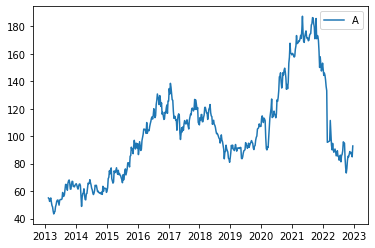

In [58]:
plt.plot(df["<DATE>"], df["<CLOSE>"])
plt.legend("Акции МосБиржи с 2013г.")

Load data from Google trends

In [98]:
pytrend = TrendReq()

def make_gtrend_table(word, year = 2013):
    ress = pd.DataFrame()
    for y in range(year, 2023):
        str_yr = str(y)
        pytrend.build_payload([word], timeframe=f"{y}-01-01 {y+1}-01-01")
        result = pytrend.interest_over_time()
        ress = pd.concat([ress, result])
    return ress

lst_of_words = ["госдолг", "мосбиржа", "экономика", "акции", "инвестиции", "портфель", "инфляция", \
    "кризис", "кредит", "доход", "капитал", "вложить", "война", "заболеваемость", "правительство", \
    "закон", "парламент", "сбербанк", "гзапром", "роснефть", "нефть", "короновирус", "covid" \
        ]

def get_pytrend_data(lst_of_words, cols):
    count = 0
    for term in lst_of_words:
        print(f"{term} get")
        c = 0
        while (c < 5):
            try:
                res = make_gtrend_table(term)
                cols[term] = res
                print(f"{term} is ready {res}")
                break
            except:
                time.sleep(5)
                c+=1


cols = {}
get_pytrend_data(lst_of_words, cols)
total_trend_data = pd.concat(cols.values(), axis=1)
total_trend_data = total_trend_data.drop(["isPartial"], axis=1)
total_trend_data["date"] = pd.to_datetime(total_trend_data["date"], format="%Y-%m-%d")
total_trend_data = total_trend_data.set_index("date")
total_trend_data

закон is ready             закон  isPartial
date                        
2013-01-06     70      False
2013-01-13     92      False
2013-01-20     94      False
2013-01-27     86      False
2013-02-03     79      False
...           ...        ...
2022-11-13     77      False
2022-11-20     75      False
2022-11-27     80      False
2022-12-04     80      False
2022-12-11     87      False

[520 rows x 2 columns]
парламент get
парламент is ready             парламент  isPartial
date                            
2013-01-06         44      False
2013-01-13         44      False
2013-01-20         65      False
2013-01-27         51      False
2013-02-03         51      False
...               ...        ...
2022-11-13         88      False
2022-11-20         88      False
2022-11-27         90      False
2022-12-04         81      False
2022-12-11         99      False

[520 rows x 2 columns]
сбербанк get
сбербанк is ready             сбербанк  isPartial
date                           
201

KeyError: 'date'

In [91]:
res = []
for i in df.index:
    try:
        int(total_trend_data.loc[i, "акции"])
        res.append([i, df.loc[i, "<CLOSE>"], *total_trend_data.loc[i,:]])
    except Exception as e:
        continue
res = pd.DataFrame(res, columns = ["date", "price", *total_trend_data.columns])
res = res.set_index("date")

In [92]:
res

,price,госдолг,мосбиржа,экономика,акции,инвестиции,портфолио,инфляция,кредит,доход,капитал,вложить,война,заболеваемость,правительство
date,,,,,,,,,,,,,,,
2013-02-10,55.00,20,0,65,43,72,85,44,79,76,78,67,56,100,92
2013-02-17,54.50,14,0,64,42,74,89,60,79,73,80,60,68,33,79
2013-02-24,52.50,20,0,67,40,72,85,67,76,75,86,50,67,66,89
2013-03-03,53.99,12,0,51,43,65,61,46,74,55,71,63,63,20,77
2013-03-10,55.00,12,0,70,38,81,71,71,87,77,88,71,83,82,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-13,88.81,9,8,56,33,42,75,30,77,70,68,34,16,12,57
2022-11-20,87.60,10,8,49,31,38,74,29,72,73,60,34,15,10,52
2022-11-27,87.02,14,7,49,31,39,75,28,75,78,60,38,14,12,53


In [93]:
scaler = StandardScaler()
scaler = scaler.fit(res)
pricedata_scaled = scaler.transform(res)
pricedata_scaled

array([[-1.38909626, -0.75793167, -1.36737219, ...,  0.42502949,
         2.39286555,  1.17836328],
       [-1.40396147, -1.0478043 , -1.36737219, ...,  1.04717264,
        -0.33015759,  0.6066855 ],
       [-1.46342231, -0.75793167, -1.36737219, ...,  0.99532738,
         1.01103291,  1.04643764],
       ...,
       [-0.43712814, -1.0478043 , -1.11374727, ..., -1.75247152,
        -1.18364245, -0.53667006],
       [-0.40293816, -1.24105272, -1.04128301, ..., -1.70062626,
        -1.10235818, -0.44871963],
       [-0.49867012, -1.28936482, -0.96881875, ..., -1.70062626,
        -0.93978964,  0.07898293]])

Построим матрицу корреляции

In [97]:
pd.DataFrame(pricedata_scaled, columns = ["price", *total_trend_data.columns]).corr()["price"]

,price,госдолг,мосбиржа,экономика,акции,инвестиции,портфолио,инфляция,кредит,доход,капитал,вложить,война,заболеваемость,правительство
price,1.000000,-0.002811,0.421087,0.247553,0.599749,0.067322,0.165607,0.201090,0.372799,0.058273,-0.161626,0.362997,-0.067502,-0.023408,-0.256202
госдолг,-0.002811,1.000000,0.110812,0.209716,0.204267,0.232789,0.106280,0.158955,-0.067527,0.242105,-0.150833,0.062657,0.167025,0.194959,-0.065213
мосбиржа,0.421087,0.110812,1.000000,0.271402,0.499865,0.166295,0.136720,0.304370,0.361480,0.144474,0.065634,0.344923,0.074854,0.031219,-0.017042
экономика,0.247553,0.209716,0.271402,1.000000,0.532948,0.594673,0.669885,0.789759,0.513651,0.685173,0.367329,0.490063,0.331001,0.464588,0.384495
акции,0.599749,0.204267,0.499865,0.532948,1.000000,0.355460,0.303837,0.574377,0.620634,0.341193,0.078246,0.568262,0.098723,0.219283,-0.037681
инвестиции,0.067322,0.232789,0.166295,0.594673,0.355460,1.000000,0.372611,0.530444,0.164123,0.667200,0.326595,0.162132,0.449981,0.427904,0.490064
портфолио,0.165607,0.106280,0.136720,0.669885,0.303837,0.372611,1.000000,0.498238,0.360605,0.658498,0.266537,0.267240,0.048146,0.326125,0.223471
инфляция,0.201090,0.158955,0.304370,0.789759,0.574377,0.530444,0.498238,1.000000,0.591201,0.638678,0.320041,0.622508,0.343997,0.491736,0.256859
кредит,0.372799,-0.067527,0.361480,0.513651,0.620634,0.164123,0.360605,0.591201,1.000000,0.316951,0.351810,0.672461,0.043021,0.184147,0.116460
доход,0.058273,0.242105,0.144474,0.685173,0.341193,0.667200,0.658498,0.638678,0.316951,1.000000,0.272112,0.213300,0.311129,0.492616,0.337089


### Training

Lets try to train model on that data

Split on train and test. X - trends and last prices, y - price after window

In [252]:
winsize = 14
X = []
y = []
for i in range(pricedata_scaled.shape[0]-winsize):
    X.append(pricedata_scaled[i:i+winsize])
    y.append(pricedata_scaled[i+winsize, -1])
X = np.array(X)
y = np.array(y)
tsplit_idx = int(len(X)*0.8)
X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

print(f"X shape {X_train.shape} test shape {X_test.shape} y shape {y_train.shape}")

X shape (1458, 14, 6) test shape (508, 14, 6) y shape (1458,)


We will use LSTM with 128 units

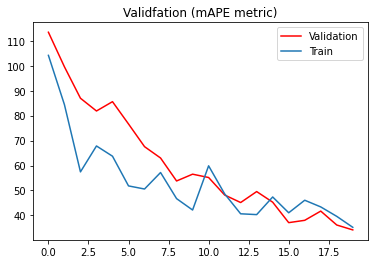

16/16 [==============================] - 1s 11ms/step
mAPE: 0.34193%
MSE (scaled): 0.070199
R2: 0.94


In [256]:
model = Sequential()
param_num=X_train.shape[2]
model.add(Input((winsize, param_num)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(metrics="mape", loss="mse")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=0)

plt.plot(history.history["val_mape"], "r-")
plt.plot(history.history["mape"])
plt.title("Validfation (mAPE metric)")
plt.legend(["Validation", "Train"])
plt.show()
y_pred = model.predict(X_test)
print(f"mAPE: {round(mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred), 5)}%")
print(f"MSE (scaled): {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 6)}")
print(f"R2: {round(r2_score(y_true=y_test, y_pred=y_pred), 2)}")

Plot stock price real and presdicted by model

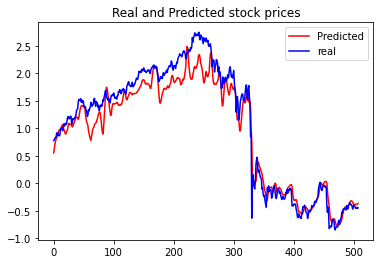

In [257]:
plt.plot(y_pred, "r")
plt.plot(y_test, "b-")
plt.legend(["Predicted", "real"])
plt.title("Real and Predicted stock prices")
plt.show()

But What if we will predict not price but the movement

### Compare with only last prices

In [247]:
winsize = 14
X = []
y = []
for i in range(pricedata_scaled.shape[0]-winsize):
    X.append(pricedata_scaled[i:i+winsize, -1:])
    y.append(pricedata_scaled[i+winsize, -1])
X = np.array(X)
y = np.array(y)
tsplit_idx = int(len(X)*0.75)
X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

print(f"X shape {X_train.shape} test shape {X_test.shape} y shape {y_train.shape}")

X shape (1474, 14, 1) test shape (492, 14, 1) y shape (1474,)


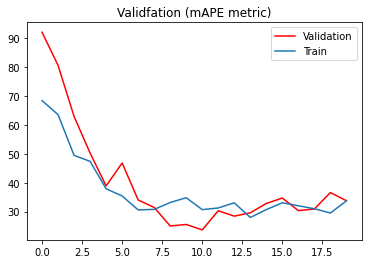

16/16 [==============================] - 0s 4ms/step
mAPE: 0.33773%
MSE (scaled): 0.012051
R2: 0.99


In [248]:
model = Sequential()
param_num=X_train.shape[2]
model.add(Input((winsize, param_num)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(metrics="mape", loss="mse")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=0)

plt.plot(history.history["val_mape"], "r-")
plt.plot(history.history["mape"])
plt.title("Validfation (mAPE metric)")
plt.legend(["Validation", "Train"])
plt.show()
y_pred = model.predict(X_test)
print(f"mAPE: {round(mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred), 5)}%")
print(f"MSE (scaled): {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 6)}")
print(f"R2: {round(r2_score(y_true=y_test, y_pred=y_pred), 2)}")

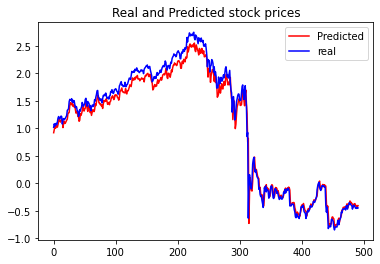

In [251]:
plt.plot(y_pred, "r")
plt.plot(y_test, "b-")
plt.legend(["Predicted", "real"])
plt.title("Real and Predicted stock prices")
plt.show()